# APPM 5720 - Homework 4

### Part 1: Approximate $au_x$ on a simple element without BCs

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import sympy code for gauss lobatto nodes
from sympy.core import S, Dummy, pi
from sympy.functions.combinatorial.factorials import factorial
from sympy.functions.elementary.trigonometric import sin, cos
from sympy.functions.elementary.miscellaneous import sqrt
from sympy.functions.special.gamma_functions import gamma
from sympy.polys.orthopolys import (legendre_poly, laguerre_poly,
                                    hermite_poly, jacobi_poly)
from sympy.polys.rootoftools import RootOf
from sympy.core.compatibility import range

In [3]:
def f(x):
    return np.exp(-1*x**2)

In [41]:
def fx(x):
    return -2*x*f(x)

In [4]:
def gauss_lobatto(n, n_digits):
    r"""
    Computes the Gauss-Lobatto quadrature [1]_ points and weights.

    The Gauss-Lobatto quadrature approximates the integral:

    .. math::
        \int_{-1}^1 f(x)\,dx \approx \sum_{i=1}^n w_i f(x_i)

    The nodes `x_i` of an order `n` quadrature rule are the roots of `P'_(n-1)`
    and the weights `w_i` are given by:

    .. math::
        &w_i = \frac{2}{n(n-1) \left[P_{n-1}(x_i)\right]^2},\quad x\neq\pm 1\\
        &w_i = \frac{2}{n(n-1)},\quad x=\pm 1

    Parameters
    ==========

    n : the order of quadrature

    n_digits : number of significant digits of the points and weights to return

    Returns
    =======

    (x, w) : the ``x`` and ``w`` are lists of points and weights as Floats.
             The points `x_i` and weights `w_i` are returned as ``(x, w)``
             tuple of lists.

    Examples
    ========

    >>> from sympy.integrals.quadrature import gauss_lobatto
    >>> x, w = gauss_lobatto(3, 5)
    >>> x
    [-1, 0, 1]
    >>> w
    [0.33333, 1.3333, 0.33333]
    >>> x, w = gauss_lobatto(4, 5)
    >>> x
    [-1, -0.44721, 0.44721, 1]
    >>> w
    [0.16667, 0.83333, 0.83333, 0.16667]

    See Also
    ========

    gauss_legendre,gauss_laguerre, gauss_gen_laguerre, gauss_hermite, gauss_chebyshev_t, gauss_chebyshev_u, gauss_jacobi

    References
    ==========

    .. [1] http://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss.E2.80.93Lobatto_rules
    .. [2] http://people.math.sfu.ca/~cbm/aands/page_888.htm
    TAKEN FROM SYMPY
    """
    x = Dummy("x")
    p = legendre_poly(n-1, x, polys=True)
    pd = p.diff(x)
    xi = []
    w = []
    for r in pd.real_roots():
        if isinstance(r, RootOf):
            r = r.eval_rational(S(1)/10**(n_digits+2))
        xi.append(r.n(n_digits))
        w.append((2/(n*(n-1) * p.subs(x, r)**2)).n(n_digits))

    xi.insert(0, -1)
    xi.append(1)
    w.insert(0, (S(2)/(n*(n-1))).n(n_digits))
    w.append((S(2)/(n*(n-1))).n(n_digits))
    return xi, w

In [5]:
def leg_eval(q,x):
    '''
    Evaluate Legendre polynomials of up to degree q at point x
    '''
    if q == 0:
        return np.array([1])
    elif q == 1:
        return np.array([1,x])
    else:
        leg_arr = np.zeros([q])
        leg_arr[0] = 1
        leg_arr[1] = x
        
        # Recursion relation for higher order Leg. polynomials
        for i in range(1,q-1):
            leg_arr[i+1] = ((2*i+1)*x*leg_arr[i] - i*leg_arr[i-1])/(i+1)
        return np.array(leg_arr)

In [16]:
def legx_eval(n,x):
    '''
    From Appelo Repo
    Return 1st derivative of Legendre polynomials
    '''
    # Initialize
    leg = np.zeros([n])
    legx = np.zeros([n])
    
    # Legendre array
    if n == 0:
        leg[0] = 1
    elif n == 1:
        leg[0] = 1
        leg[1] = x
    else:
        leg[0] = 1
        leg[1] = x
        for i in range(1,n-1):
            leg[i+1] = ((2*i+1)*x*leg[i] - i*leg[i-1])/(i+1)
            
    # d/dx(Legendre array)
    if n == 0:
        legx[0] = 0
        return legx
    elif n == 1:
        legx[0] = 0
        legx[1] = 1
        return legx
    else:
        legx[0] = 0
        legx[1] = 1
        for i in range(1,n-1):
            legx[i+1] = legx[i-1] + (2*(i+1)-1)*legx[i]
        return legx

In [12]:
# Parameters
num_grdpts = 2
num_elems = num_grdpts - 1
num_nodes = 8
a = 5     # arbitary value

grdpts = np.array([0.0, 0.3])
degree_vec = np.array([6, 6])
q = degree_vec[0]

In [7]:
### --- Acquire coefficients u(hat)_k --- ###
uh = np.zeros([degree_vec[0], num_elems])

# Precompute Ldgr polynomials at LGL nodes
r_lgl, w_lgl = gauss_lobatto(num_nodes,16)
r_lgl, w_lgl = np.array(r_lgl), np.array(w_lgl)

lgdr_arr = np.zeros([degree_vec[0], num_nodes])
for i in range(num_nodes):
    lgdr_arr[:,i] = leg_eval(degree_vec[0], r_lgl[i])

### For a single element i
i = 0
xL = grdpts[i]
xR = grdpts[i+1]

# Calculate f(x(r_j))
# Map (xL, xR) -> (-1,1)
x_lgl = 1/2*((xR-xL)*r_lgl + (xR+xL))
x_lgl = x_lgl.astype(float)

for l in range(degree_vec[0]):
    for j in range(num_nodes):
        uh[l,i] += (2*l+1)/2 * w_lgl[j] * lgdr_arr[l,j] * f(x_lgl[j])

In [39]:
### --- Acquire coefficients b(hat)_k --- ###
### Calculate integral over element of (P_l * P'_k) through Gaussian quadrature
S = np.zeros([q, q])            # Unsure about the dimensions... (q+1) x (q+1) maybe?
M = np.zeros([q, q])            # "Mass matrix", will be diagonal

# Precalculate Lgdr derivatives as LGL nodes
lgdrx_arr = np.zeros([q, num_nodes])
for i in range(num_nodes):
    lgdrx_arr[:,i] = legx_eval(q, r_lgl[i])
    
# Gaussian quadrature
for l in range(q):
    for j in range(q):
        S[j,l] = w_lgl[j] * lgdr_arr[l,j] * lgdrx_arr[l,j]
        
### L2 Norm of Lgdr products
for k in range(q):
    M[k,k] = 2/(2*k+1)
    
### b(hat)_k calculation
# bh = np.dot(a*np.linalg.inv(M)*S,uh)
bh = np.matmul(a*np.linalg.inv(M), S)
bh = np.matmul(bh, uh)

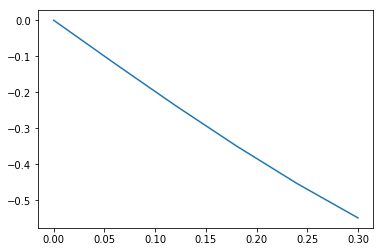

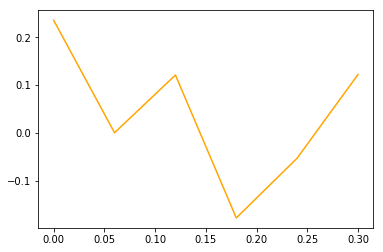

In [50]:
### --- Visualize true fcn values to approximation --- ###
true_fcn = fx(np.linspace(xL, xR, q))

r_dom = (2*np.linspace(xL,xR, q) - (xR+xL))/(xR-xL)   #r(x) for the approximation
approx_fcn = np.zeros([q])
for i in range(len(r_dom)):
    approx_lgl = leg_eval(q, r_dom[i])
    approx_fcn[i] = np.dot(np.squeeze(bh),approx_lgl)
    
plt.figure()
plt.plot(np.linspace(xL, xR, q), true_fcn)
plt.show()

plt.figure()
plt.plot(np.linspace(xL,xR, q), approx_fcn, 'orange')
plt.show()

In [40]:
bh

array([[  2.59914111e-04],
       [  1.43511331e-02],
       [  1.03944677e-01],
       [  2.21579341e-01],
       [  7.45800960e-02],
       [ -2.92545536e-01]])